In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scvi
import math
from glob import glob
import geosketch
import matplotlib.pyplot as plt
%matplotlib inline

Global seed set to 0


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated.h5ad")

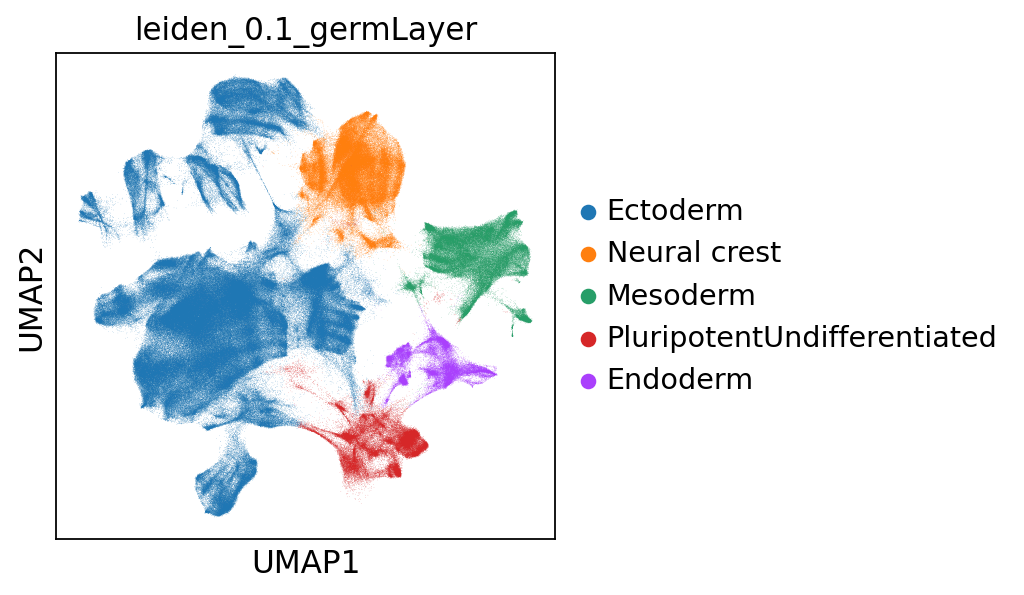

In [4]:
sc.pl.umap(adata, color="leiden_0.1_germLayer")

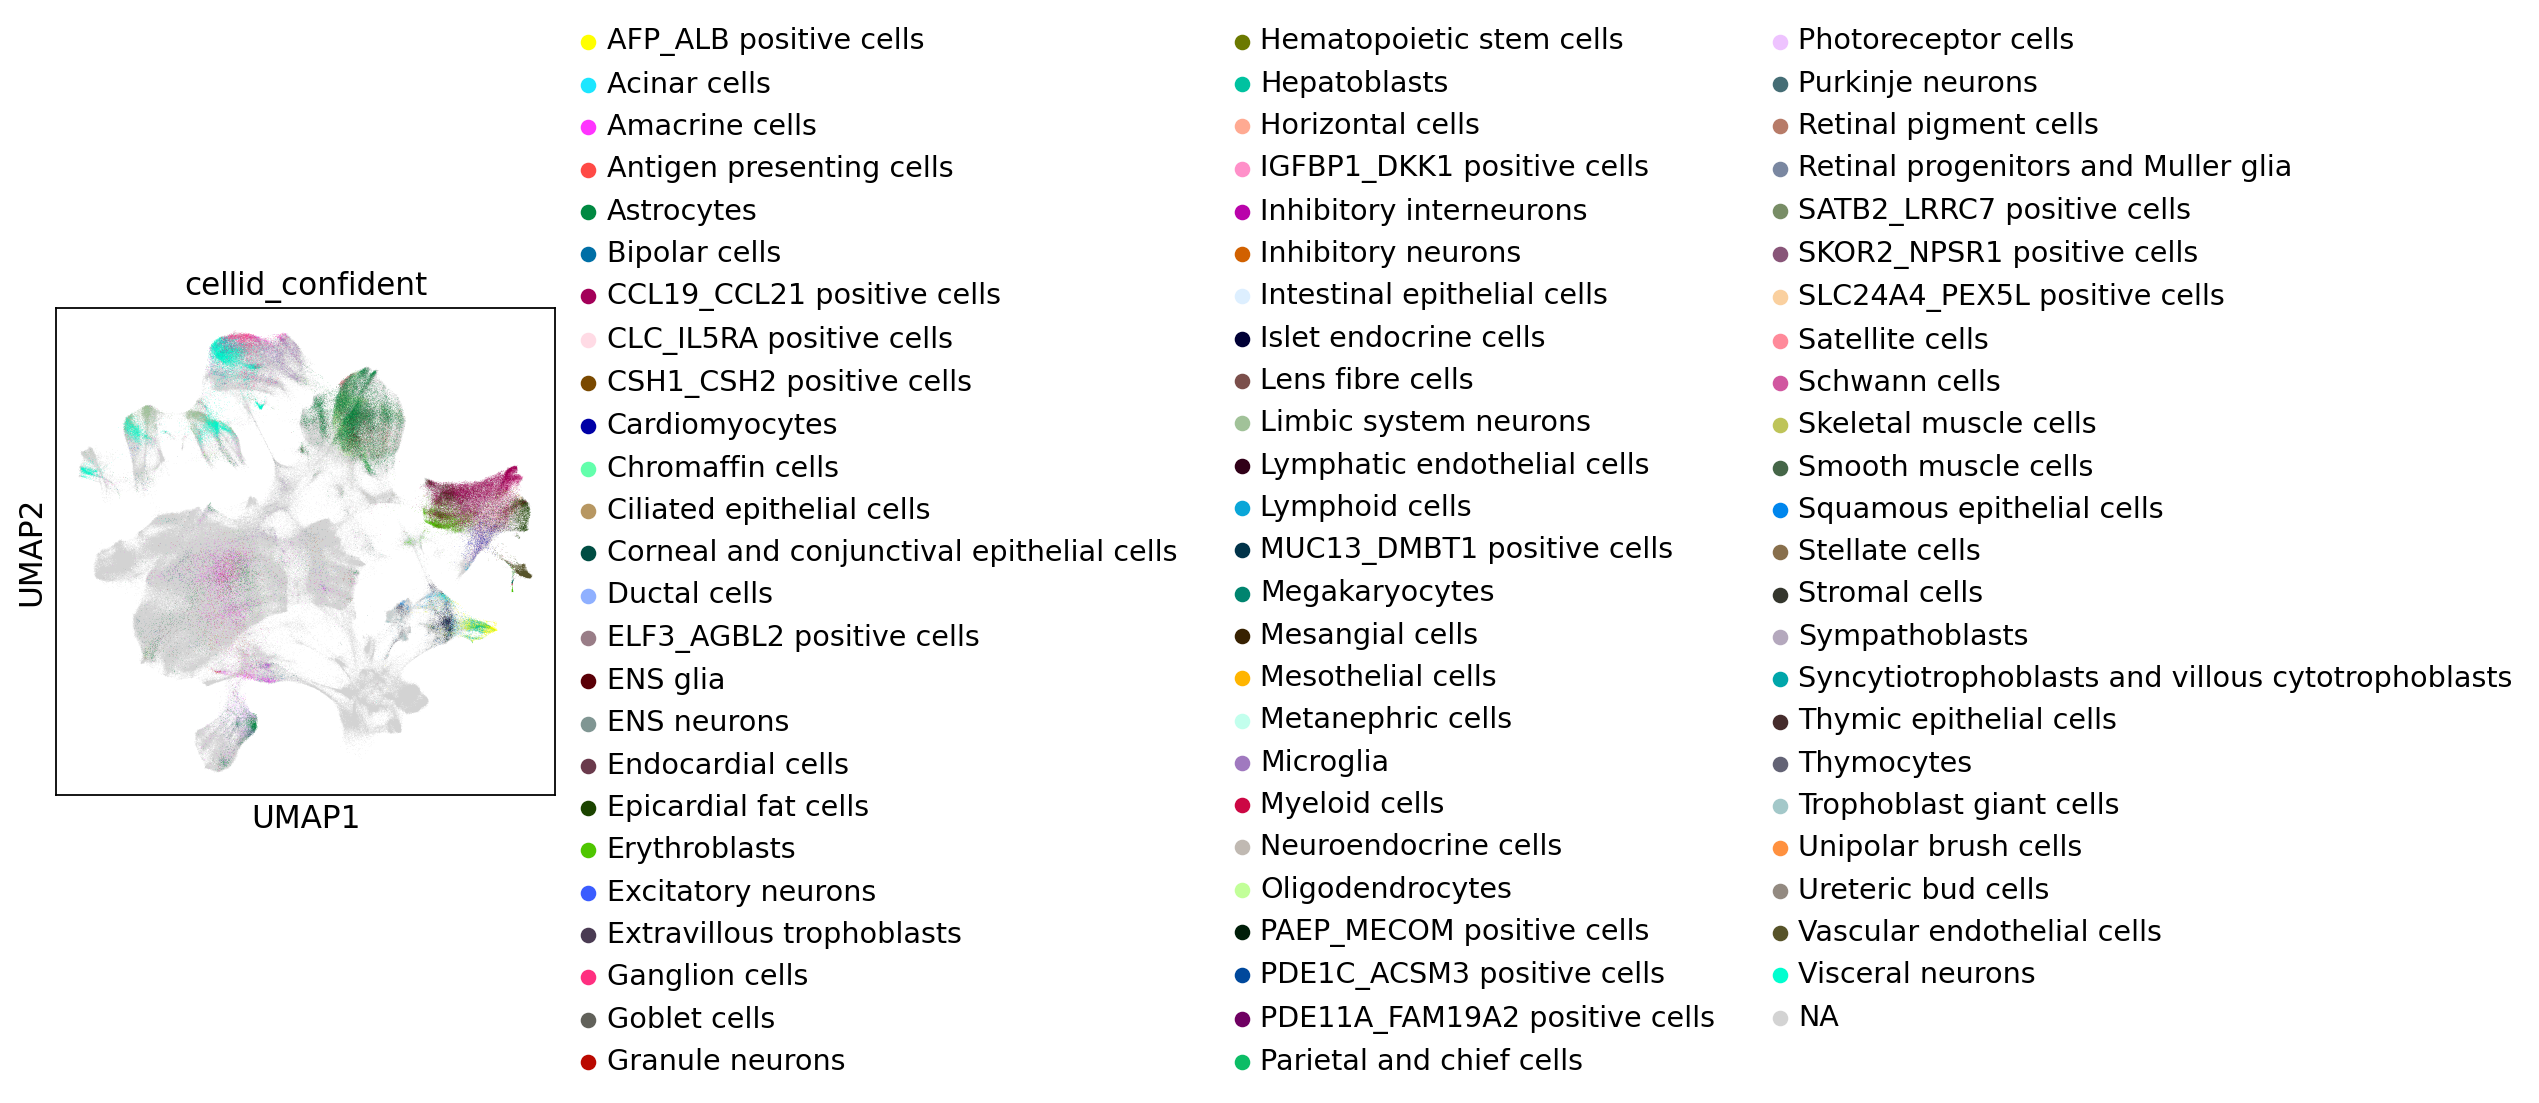

In [6]:
sc.pl.umap(adata, color="cellid_confident")

In [12]:
np.sum(adata.obs['cellid_annotation'].isna())

508804

Want to look specifically at the cardiomyocyte, hepatoblast, and ENS neuron markers

In [8]:
adata.obs['cellid_confident_sub'] = np.where(adata.obs['cellid_confident'].isin(['ENS neurons', 'ENS glia', 'Cardiomyocytes', 
                                                                                 'Epicardial fat cells', 'Hepatoblasts', 
                                                                                'Goblet cells']),
                                             adata.obs['cellid_confident'], np.nan)

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cellid_confident_sub' as categorical
/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


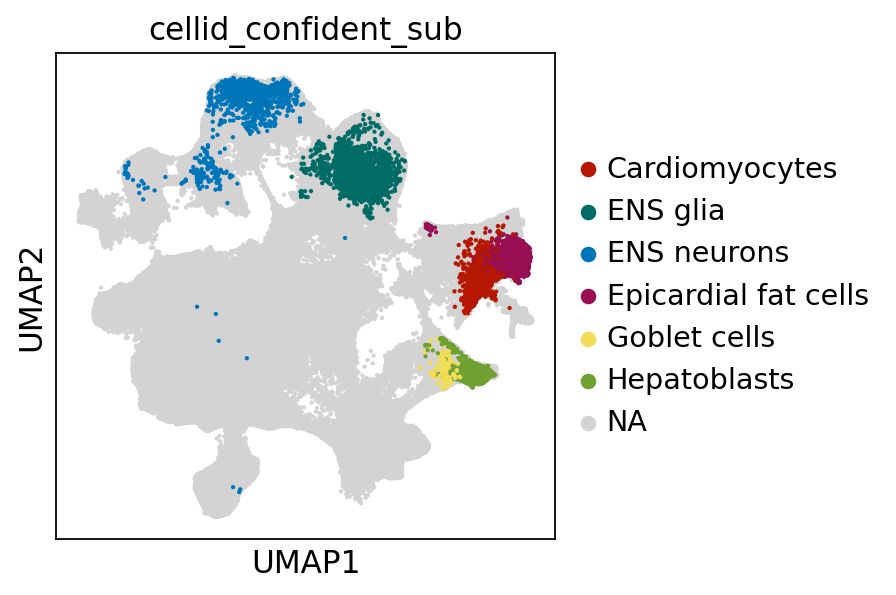

In [9]:
sc.pl.umap(adata, color='cellid_confident_sub', groups=['ENS neurons', 'ENS glia', 'Cardiomyocytes', 'Epicardial fat cells', 'Hepatoblasts', 'Goblet cells'], size=15,
          palette={"Cardiomyocytes": "#B51700", "Epicardial fat cells": "#970E53",
                   "ENS neurons": "#0076BA", "ENS glia": "#006C65",
                   "Hepatoblasts": "#6FA031", "Goblet cells": "#F2DD56"})

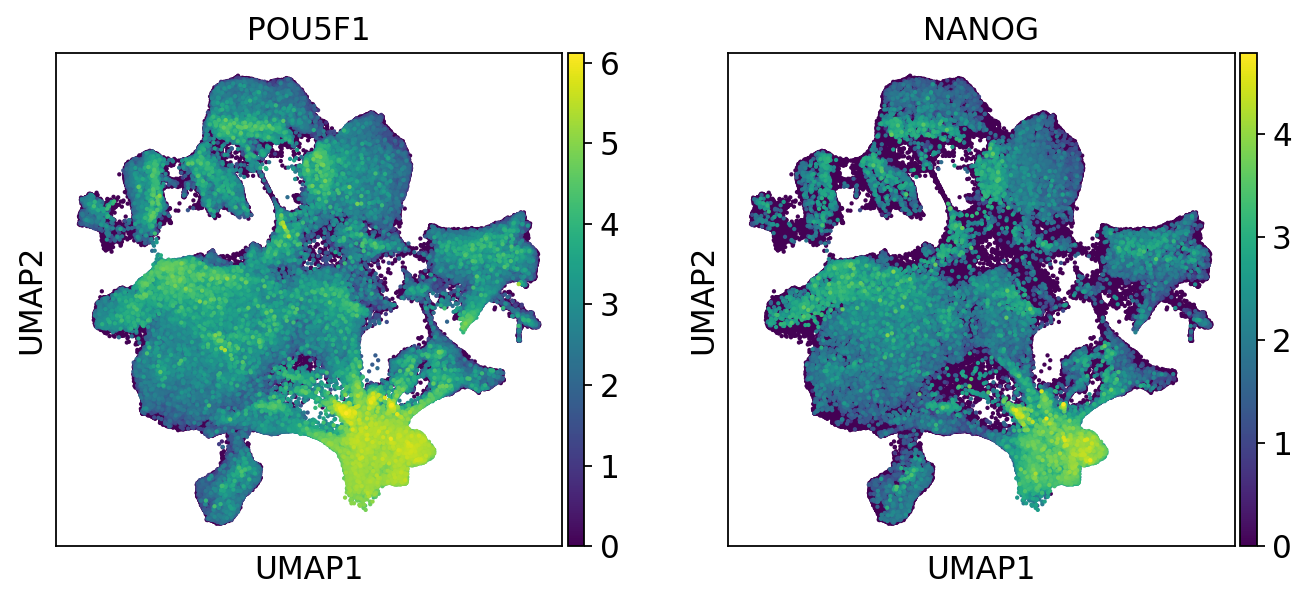

In [14]:
sc.pl.umap(adata, color=['POU5F1', 'NANOG'], size=15, cmap="viridis")

Let's load the HIPPO clusters for these cells as well

In [17]:
hippo = pd.read_csv("/project2/gilad/ktayeb/ebqtl-workflowr/output/lighthippo/germlayer/lighthippo_summary.tsv", sep="\t", index_col="cell")

In [18]:
hippo = hippo.reindex(adata.obs.index)
hippo

group    size  \
cell                                                        
ACAGCCGCATCGGATT-13               Ectoderm_3_of_5   18738   
CGAAGTTAGTATCTGC-29                      Mesoderm   81738   
CCACTTGGTACGTAGG-82               Ectoderm_2_of_5  117926   
AGAGAGCCAGCAGGAT-64               Ectoderm_1_of_5  224956   
TGTCAGAAGTTGCCTA-55               Ectoderm_5_of_5  158376   
...                                           ...     ...   
CACGAATAGTATAGGT-99               Ectoderm_1_of_5  224956   
TAACACGAGTTGGACG-3                Ectoderm_5_of_5  158376   
AGACACTCACATATCG-34               Ectoderm_1_of_5  224956   
GCCAGGTGTAATACCC-18   PluripotentUndifferentiated   54241   
TGTGTGACACAAGCTT-102              Ectoderm_1_of_5  224956   

                                                 k5  \
cell                                                  
ACAGCCGCATCGGATT-13               Ectoderm_3_of_5_5   
CGAAGTTAGTATCTGC-29                      Mesoderm_2   
CCACTTGGTACGTAGG-82               Ectoderm_2_of_5_2   
AGAGAGCCAGCAGGAT-64               Ectoderm_1_of_5_1   
TGTCAGAAGTTGCCTA-55               Ectoderm_5_of_5_2   
...                                             ...   
CACGAATAGTATAGGT-99               Ectoderm_1_of_5_5   
TAACACGAGTTGGACG-3                Ectoderm_5_of_5_4   
AGACACTCACATATCG-34               Ectoderm_1_of_5_1   
GCCAGGTGTAATACCC-18   PluripotentUndifferentiated_3   
TGTGTGACACAAGCTT-102              Ectoderm_1_of_5_4   

                                                k10  \
cell                                                  
ACAGCCGCATCGGATT-13               Ectoderm_3_of_5_9   
CGAAGTTAGTATCTGC-29                      Mesoderm_8   
CCACTTGGTACGTAGG-82               Ectoderm_2_of_5_2   
AGAGAGCCAGCAGGAT-64               Ectoderm_1_of_5_1   
TGTCAGAAGTTGCCTA-55               Ectoderm_5_of_5_6   
...                                             ...   
CACGAATAGTATAGGT-99               Ectoderm_1_of_5_5   
TAACACGAGTTGGACG-3                Ectoderm_5_of_5_4   
AGACACTCACATATCG-34               Ectoderm_1_of_5_1   
GCCAGGTGTAATACCC-18   PluripotentUndifferentiated_7   
TGTGTGACACAAGCTT-102              Ectoderm_1_of_5_9   

                                                 k20  \
cell                                                   
ACAGCCGCATCGGATT-13                Ectoderm_3_of_5_9   
CGAAGTTAGTATCTGC-29                       Mesoderm_8   
CCACTTGGTACGTAGG-82                Ectoderm_2_of_5_2   
AGAGAGCCAGCAGGAT-64               Ectoderm_1_of_5_12   
TGTCAGAAGTTGCCTA-55                Ectoderm_5_of_5_6   
...                                              ...   
CACGAATAGTATAGGT-99               Ectoderm_1_of_5_15   
TAACACGAGTTGGACG-3                 Ectoderm_5_of_5_4   
AGACACTCACATATCG-34               Ectoderm_1_of_5_17   
GCCAGGTGTAATACCC-18   PluripotentUndifferentiated_11   
TGTGTGACACAAGCTT-102               Ectoderm_1_of_5_9   

                                                 k50  \
cell                                                   
ACAGCCGCATCGGATT-13               Ectoderm_3_of_5_43   
CGAAGTTAGTATCTGC-29                       Mesoderm_8   
CCACTTGGTACGTAGG-82               Ectoderm_2_of_5_22   
AGAGAGCCAGCAGGAT-64               Ectoderm_1_of_5_50   
TGTCAGAAGTTGCCTA-55                Ectoderm_5_of_5_6   
...                                              ...   
CACGAATAGTATAGGT-99               Ectoderm_1_of_5_15   
TAACACGAGTTGGACG-3                Ectoderm_5_of_5_33   
AGACACTCACATATCG-34               Ectoderm_1_of_5_17   
GCCAGGTGTAATACCC-18   PluripotentUndifferentiated_30   
TGTGTGACACAAGCTT-102               Ectoderm_1_of_5_9   

                                                k100  
cell                                                  
ACAGCCGCATCGGATT-13               Ectoderm_3_of_5_43  
CGAAGTTAGTATCTGC-29                      Mesoderm_78  
CCACTTGGTACGTAGG-82               Ectoderm_2_of_5_22  
AGAGAGCCAGCAGGAT-64               Ectoderm_1_of_5_86  
TGTCAGAAGTTGCCTA-55           

In [19]:
adata.obs['hippo_group'] = hippo['group']
adata.obs['hippo_k5'] = hippo['k5']

In [20]:
adata.obs['hippo_k5'] = [s.replace("Ectoderm", "ect").replace("_of_5", "").replace("Endoderm", "end").replace("Mesoderm", "mes").replace("Neural_crest", "nc").replace("PluripotentUndifferentiated", "ipsc")
                         for s in adata.obs['hippo_k5']]
adata.obs['hippo_k5'] = adata.obs['hippo_k5'].astype("category")

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'hippo_group' as categorical


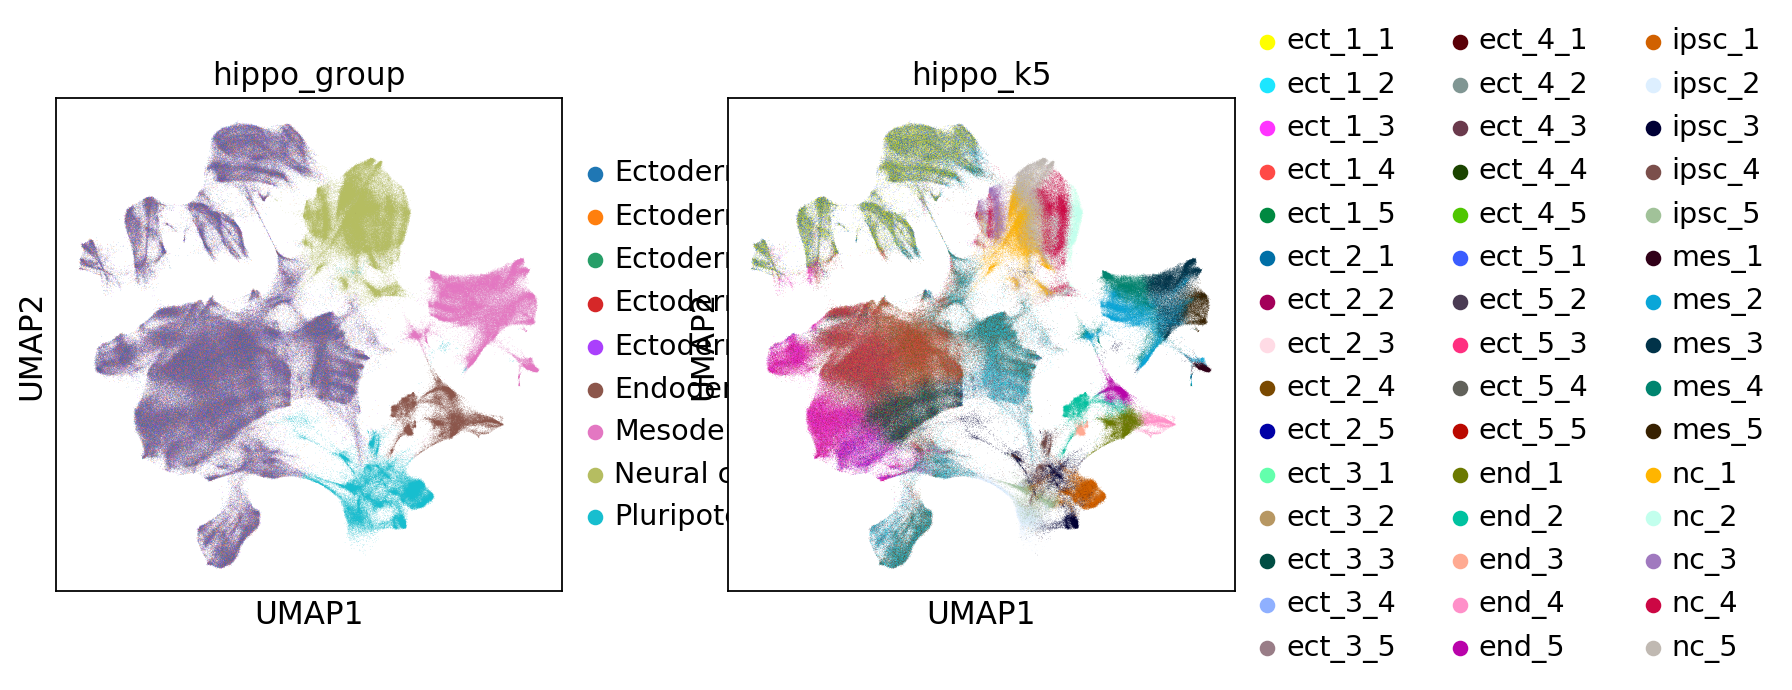

In [14]:
sc.pl.umap(adata, color=["hippo_group", "hippo_k5"])

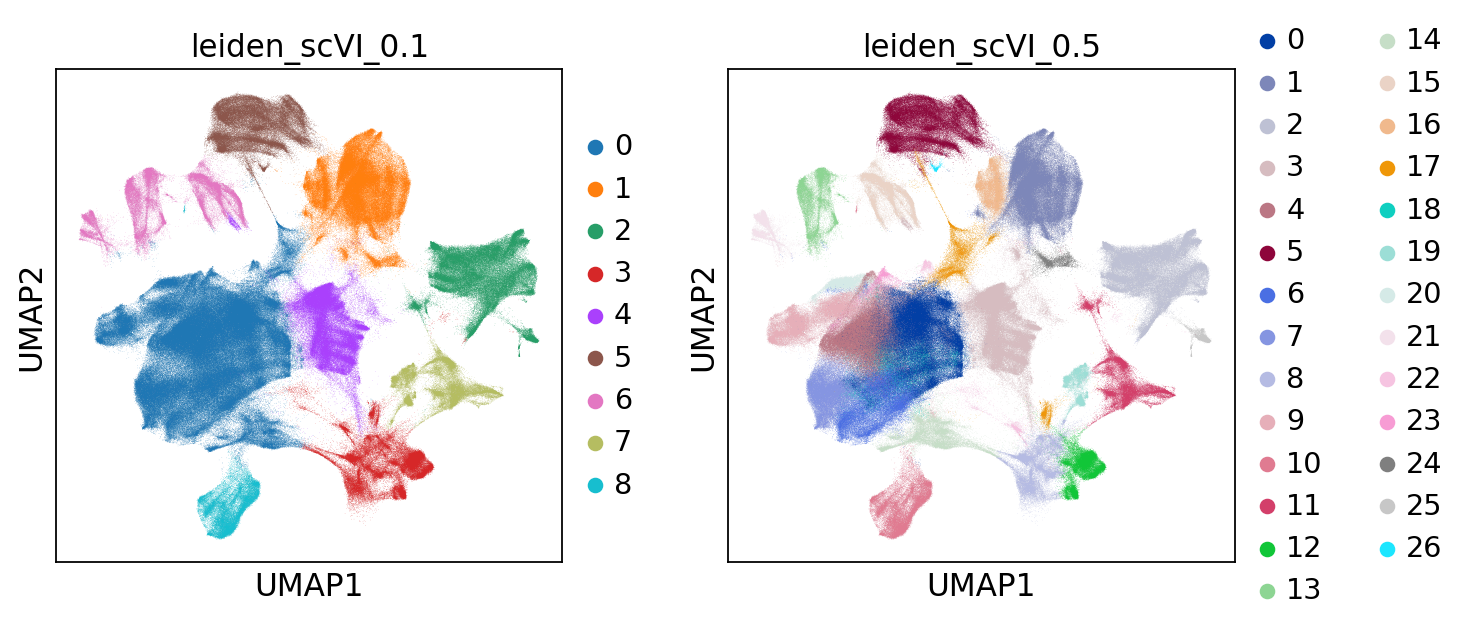

In [15]:
sc.pl.umap(adata, color=['leiden_scVI_0.1', 'leiden_scVI_0.5'])

## PAGA Analysis

Low resolution - germ layer assignments

In [16]:
sc.tl.paga(adata, groups="leiden_0.1_germLayer")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:33)


--> added 'pos', the PAGA positions (adata.uns['paga'])


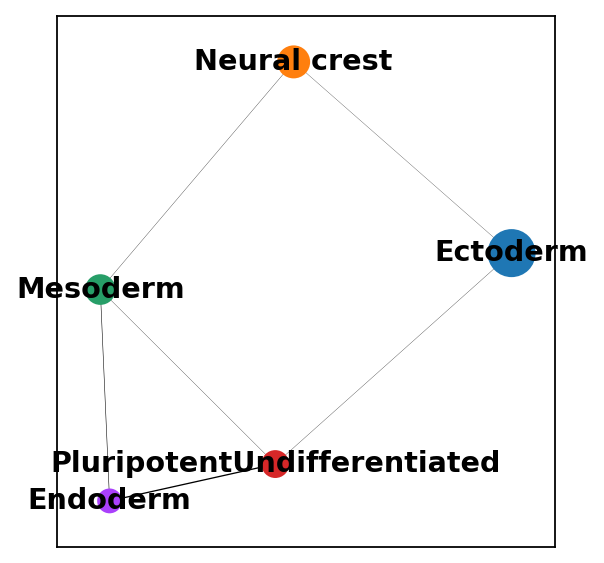

In [19]:
sc.pl.paga(adata)

Higher resolution - using HIPPO clusters

In [20]:
sc.tl.paga(adata, groups="hippo_k5")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:01:04)


--> added 'pos', the PAGA positions (adata.uns['paga'])


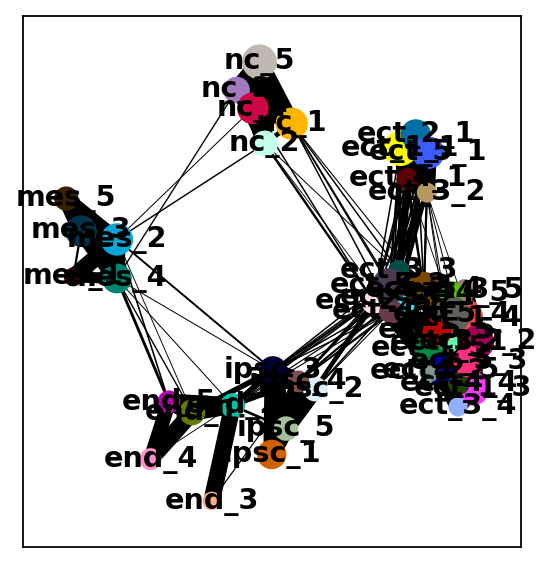

In [25]:
sc.pl.paga(adata, threshold=0.05)

Yikes. Let's go back to just the regular hippo results

In [106]:
adata.obs['hippo_k5_codes'] = adata.obs['hippo_k5'].cat.codes
adata.obs['hippo_k5_codes'] = adata.obs['hippo_k5_codes'].astype("category")

In [98]:
code_mapper = dict(zip(adata.obs['hippo_k5'].cat.codes, adata.obs['hippo_k5'].cat.categories))

In [107]:
sc.tl.paga(adata, groups="hippo_k5_codes")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:01:04)


--> added 'pos', the PAGA positions (adata.uns['paga'])


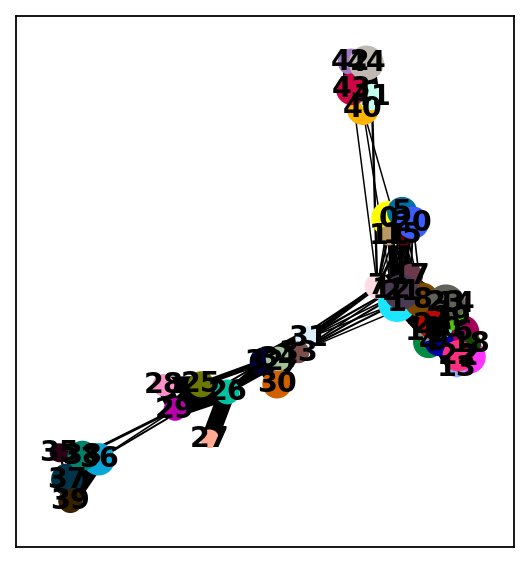

In [108]:
sc.pl.paga(adata, threshold=0.0875)

## Geometric Sketching to Preserve Transition States

In [22]:
ncells=50000
dimred = adata.obsm['X_scVI']
sketch_index = geosketch.gs(dimred, ncells, replace=False)

In [23]:
adata_sketch = adata[sketch_index]

In [24]:
adata_sketch.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated_sketch.h5ad")

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1236: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'hippo_group' as categorical


In [4]:
adata_sketch = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated_sketch.h5ad")

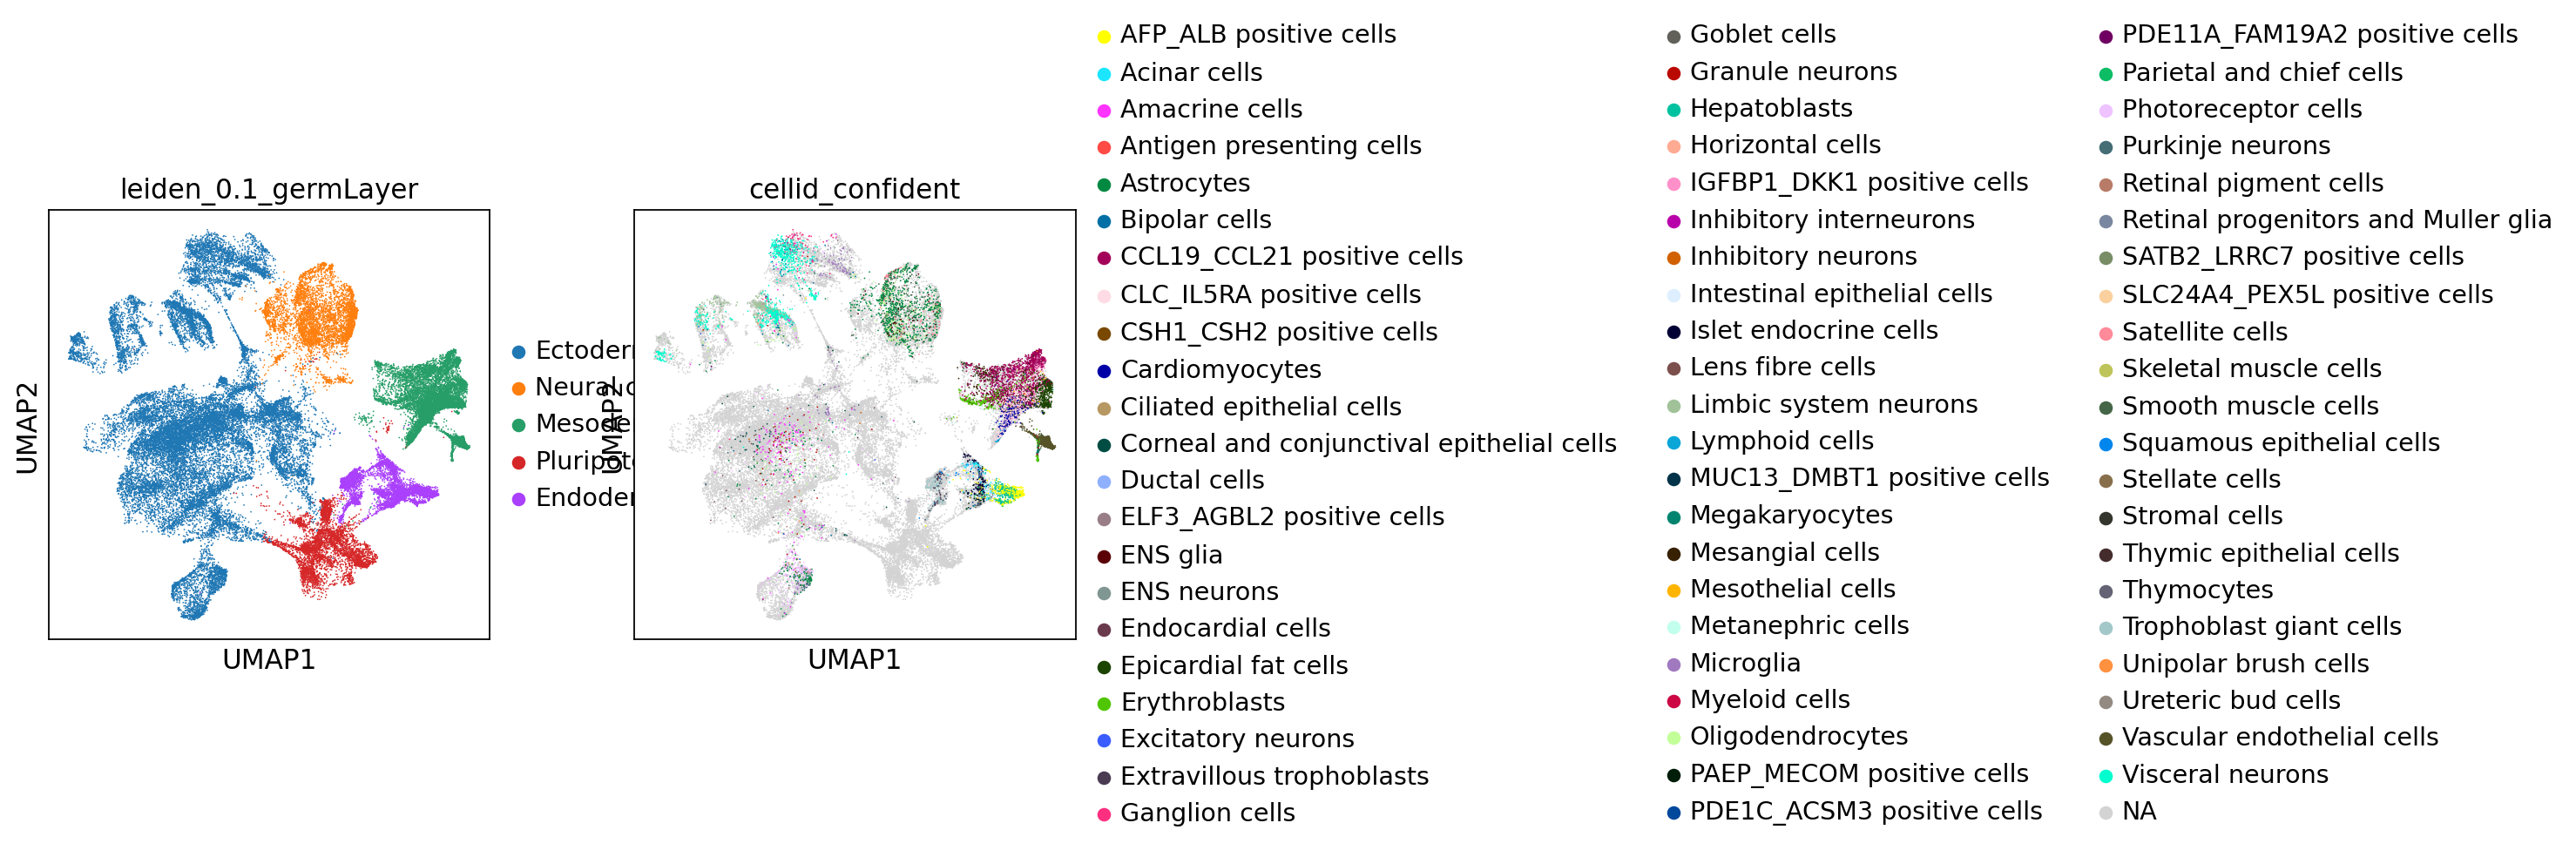

In [27]:
sc.pl.umap(adata_sketch, color=["leiden_0.1_germLayer", "cellid_confident"])

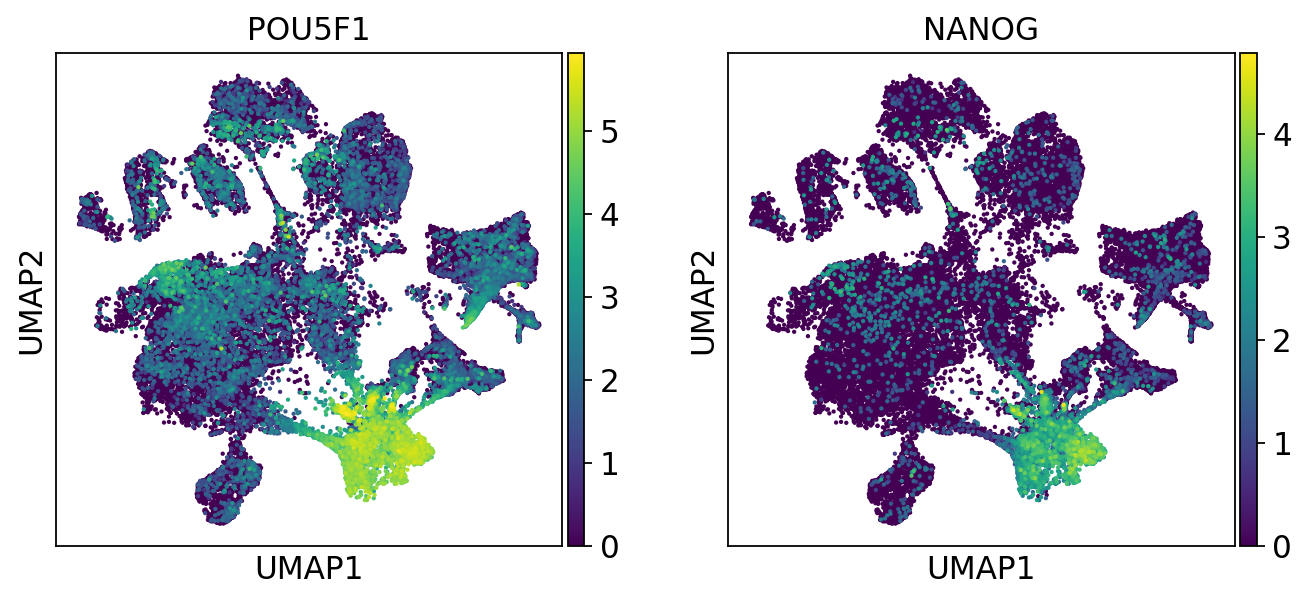

In [16]:
sc.pl.umap(adata_sketch, color=["POU5F1", "NANOG"], size=15, vmin="", vmax="")

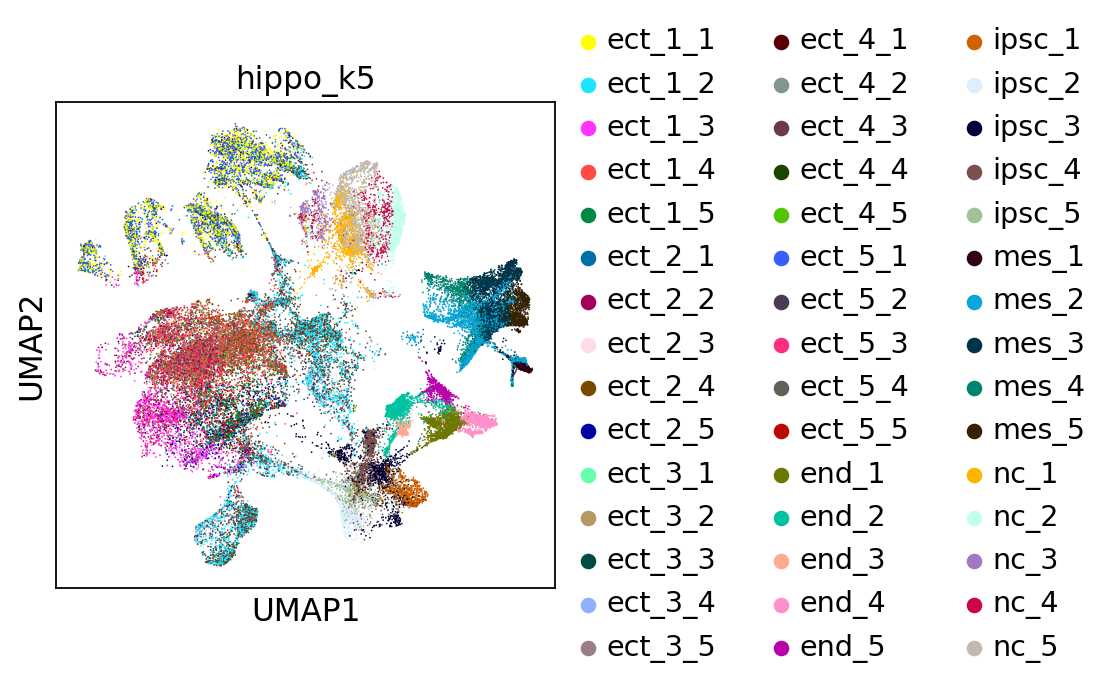

In [28]:
sc.pl.umap(adata_sketch, color='hippo_k5')

In [33]:
adata_sketch

AnnData object with n_obs × n_vars = 50000 × 5000
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id_x', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'Z_0', 'Z_1', 

In [35]:
sc.pp.neighbors(adata_sketch, use_rep="X_scVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)


In [45]:
sc.tl.paga(adata_sketch, groups="hippo_k5")

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:04)


--> added 'pos', the PAGA positions (adata.uns['paga'])


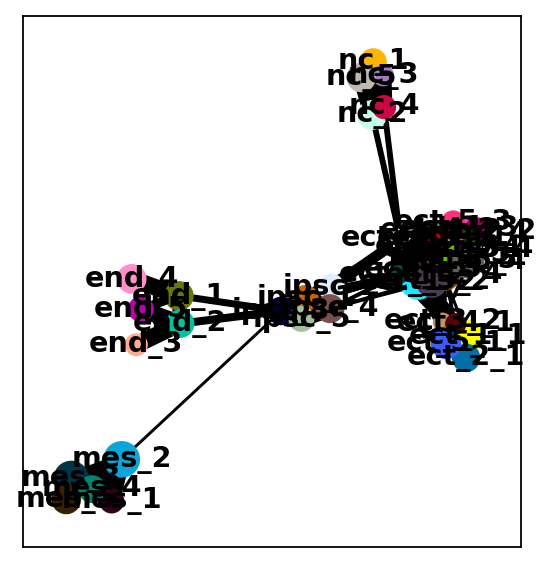

In [53]:
sc.pl.paga(adata_sketch, threshold = 0.175)

In [38]:
sc.tl.draw_graph(adata_sketch, init_pos="paga")

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:09:28)


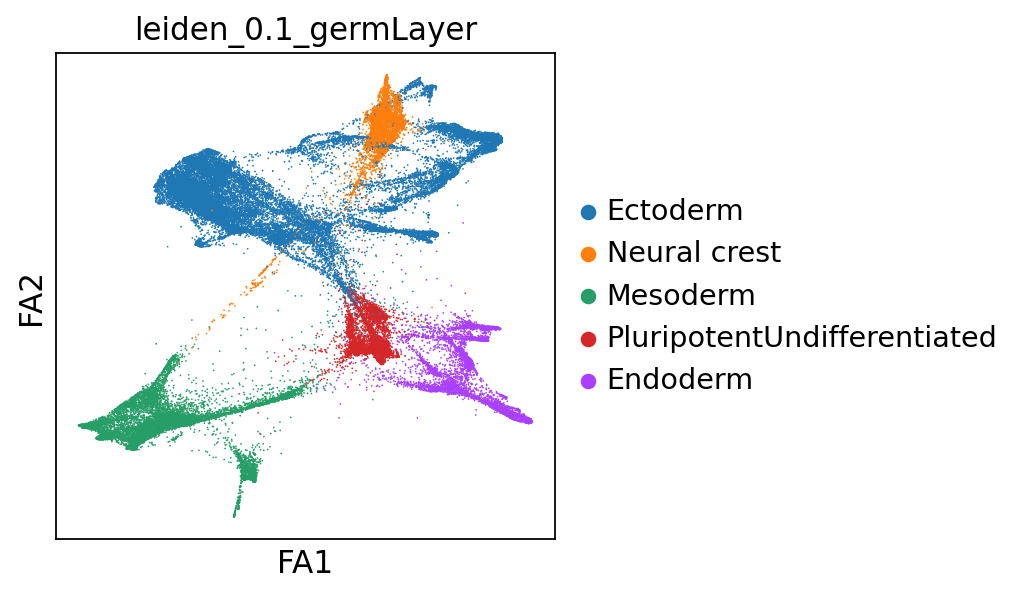

In [39]:
sc.pl.draw_graph(adata_sketch, color='leiden_0.1_germLayer')

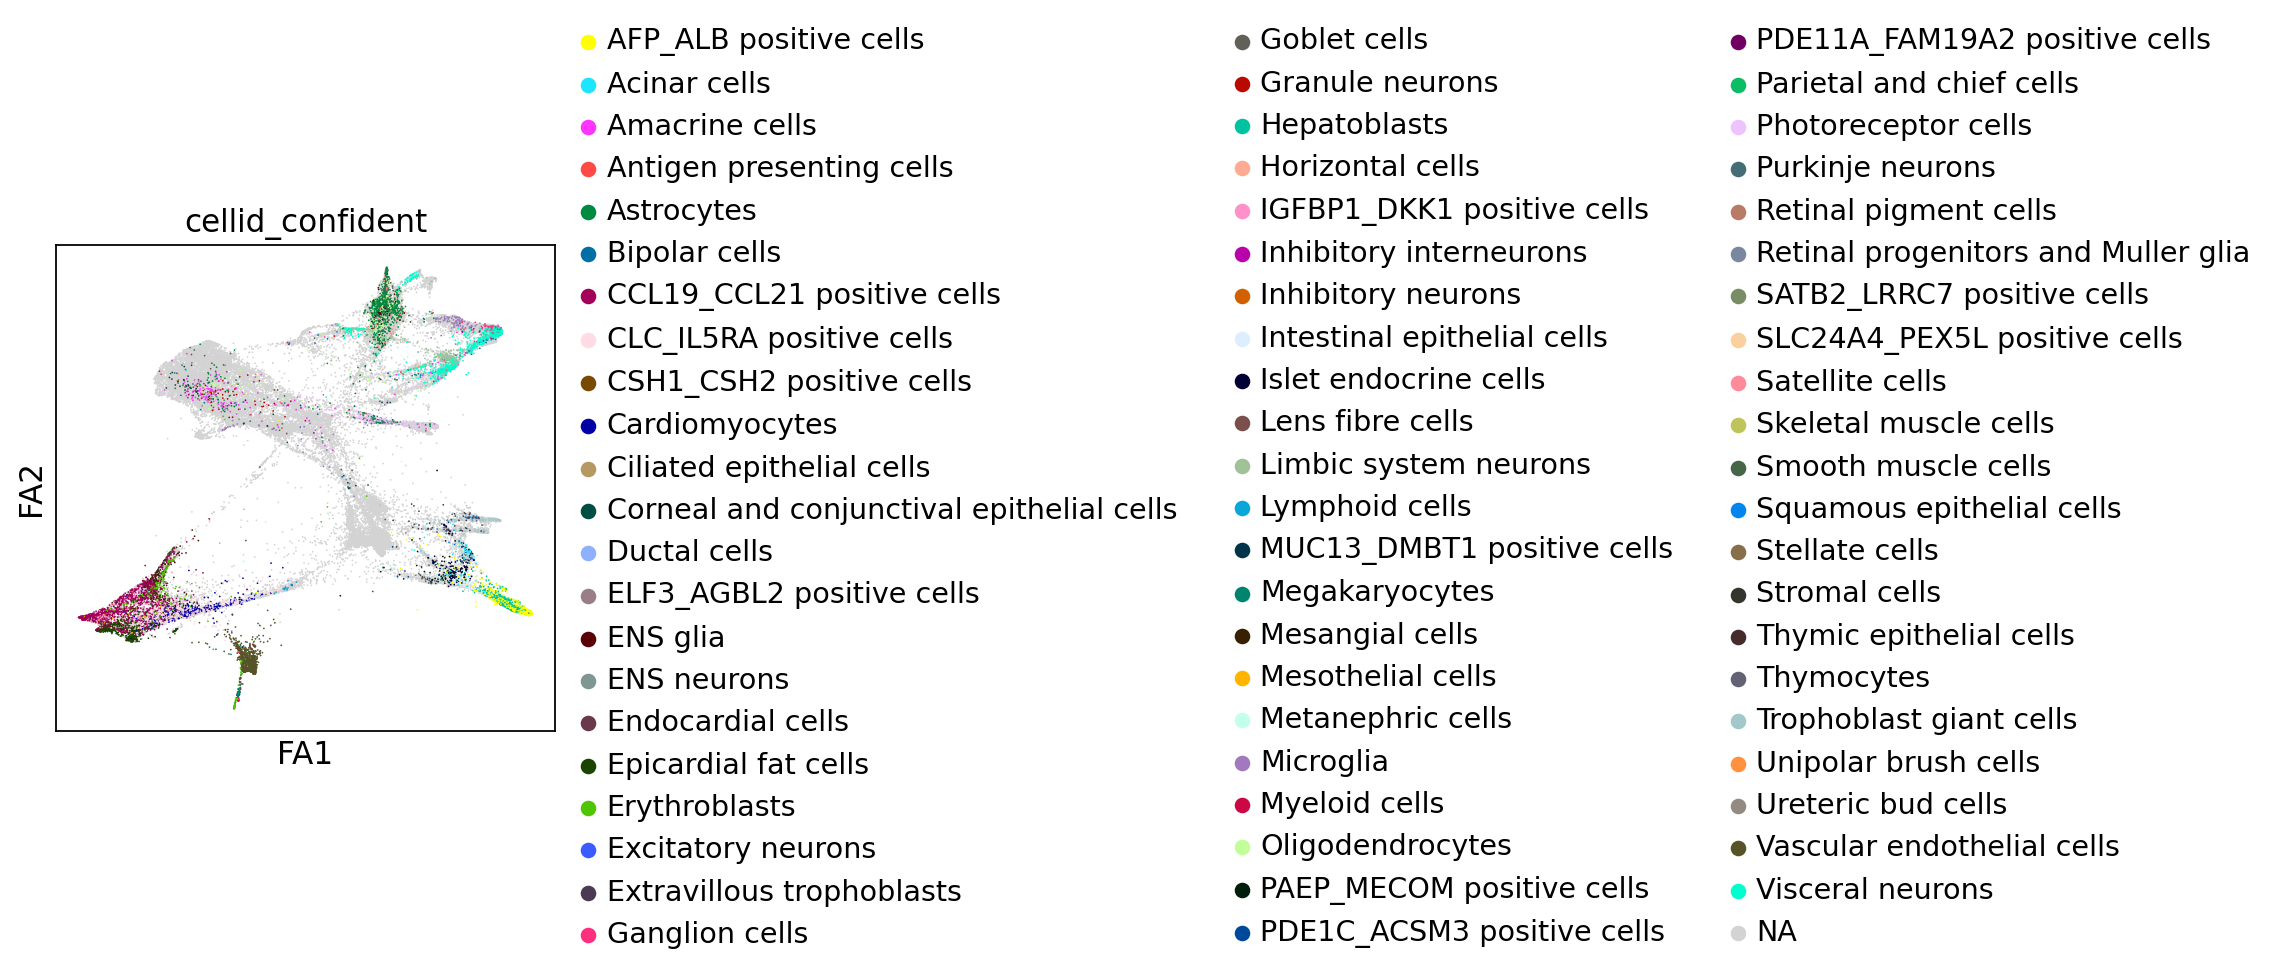

In [40]:
sc.pl.draw_graph(adata_sketch, color=['cellid_confident'])

## Single lineage isolation

In [71]:
mesendo = adata[adata.obs['leiden_0.1_germLayer'].isin(['PluripotentUndifferentiated', 'Endoderm', 'Mesoderm'])]

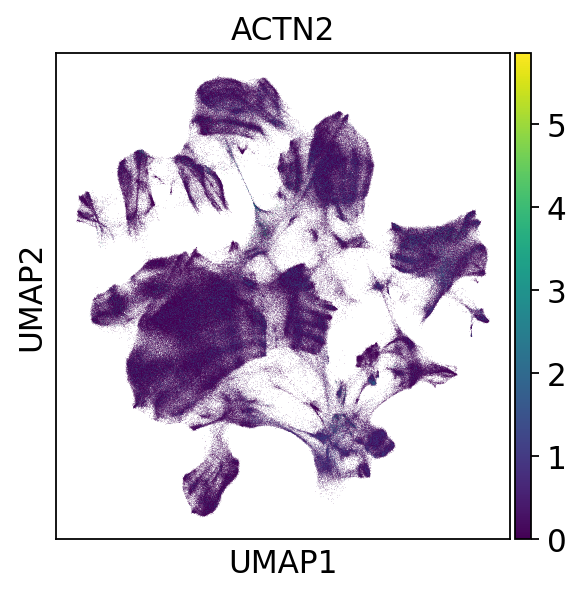

In [77]:
sc.pl.umap(adata, color=['ACTN2'])

In [72]:
sc.pp.neighbors(mesendo, use_rep="X_scVI")

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:42)


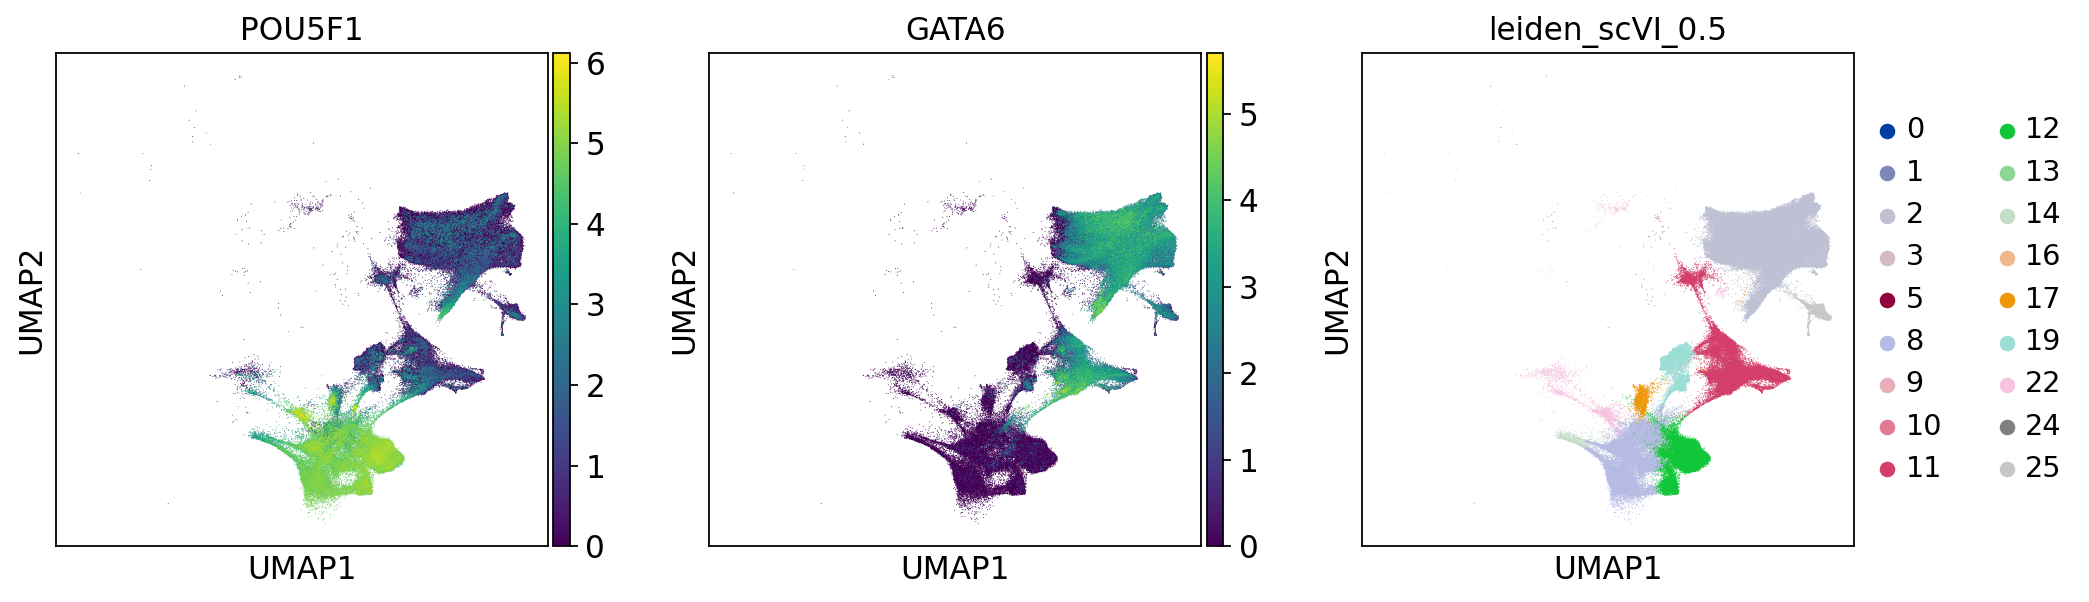

In [74]:
sc.pl.umap(mesendo, color=['POU5F1', 'GATA6', 'leiden_scVI_0.5'])

In [57]:
sc.tl.diffmap(endo)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.998065   0.9954533  0.99063647 0.9897878  0.9881058
     0.9843054  0.9828719  0.98207915 0.97866803 0.97547346 0.97414654
     0.9720048  0.97189206 0.9711766 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:08)


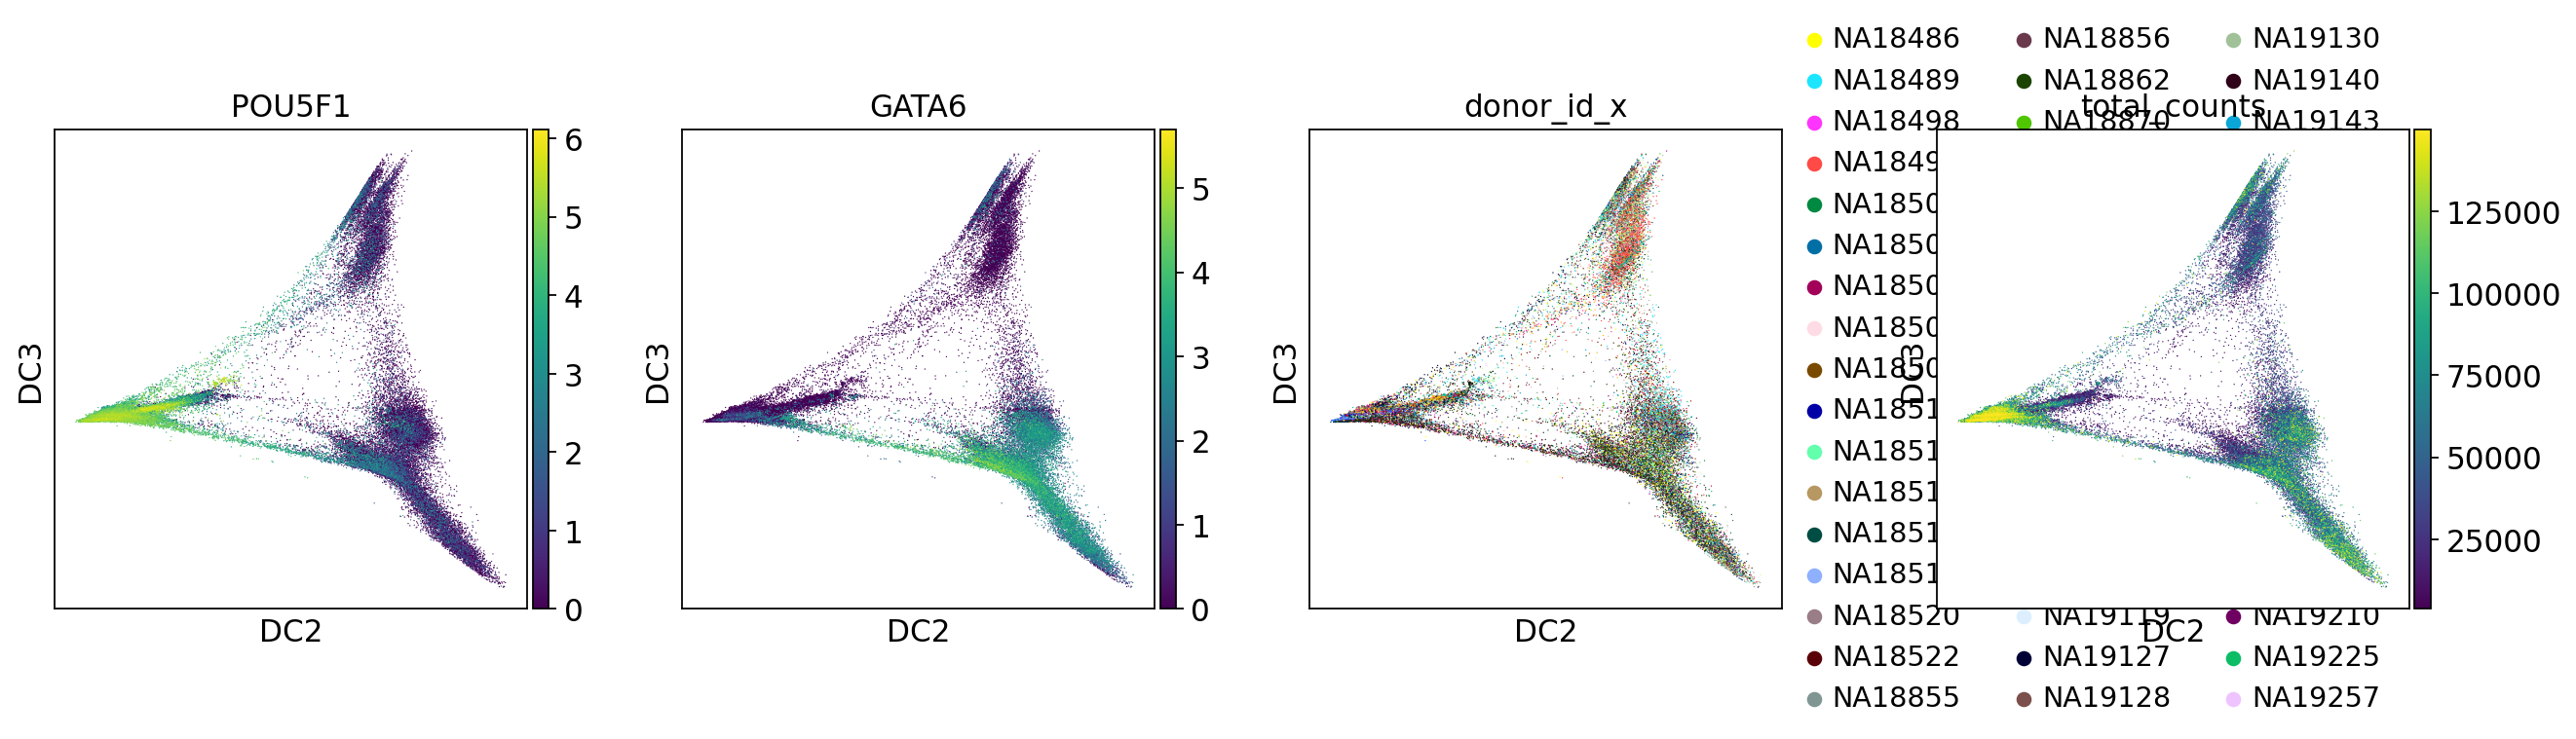

In [70]:
sc.pl.diffmap(endo, dimensions=[(1,2)], color=['POU5F1', 'GATA6', 'donor_id_x', 'total_counts'])

In [66]:
list(endo.obs.columns)

['sample_id',
 'Collection.Date',
 'Lane',
 'Sample.ID',
 'cDNA.amp.cycles',
 'cDNA.total.yield',
 'library.prep.batch',
 'Sequencing.batch',
 'col.group',
 'donor_id_x',
 'prob_max',
 'prob_doublet',
 'n_vars',
 'best_singlet',
 'best_doublet',
 'doublet_logLikRatio',
 'Line.True',
 'Line.StockLabel',
 'contaminated',
 'swapped',
 'Feeder.passage',
 'Feeder.Free.passage',
 'sex',
 'Formation.replicate',
 'collection.replicate',
 'formation.date',
 'visual.confluence',
 'total.cells.per.lane..correct.',
 'X..Viable..based.on.average.of.two.counts.',
 'days.maintained.in.LD.prior.to.formation',
 'who.dissociated.the.lines.for.formation',
 'cell.counter.correction',
 'comments',
 'collection.date',
 'collection.group.label',
 'EB.appearance.notes',
 'dissociated.by.',
 'approx..time.in.accumax..in.minutes.',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_mt',
 'pct_counts_mt',
 '_scvi_batch',
 '_scvi_labels',
 '_scvi_local_l_mean',
 '_scvi_local_l_var',
 'Z_0',
 'Z_1',
 'Z_2',
 'Z